In [34]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import EfficientNetV2B0  # Use EfficientNetV2B0, or any other variant like EfficientNetV2M, EfficientNetV2L
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras import layers, models, applications, optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adamax

In [88]:
#VARIABLES FOR TESTING
#---------------------
# imagesize = 128, 128
imagesize = 224, 224 #224,224 in final
fullimagesize = 224,224,3 #224,224,3 in final
#---------------------

#path to our cropped images
dataset_path = 'archive/crop/'

#splitting into training and validation
train_data = image_dataset_from_directory(
    dataset_path,
    validation_split = 0.3,
    seed = 64,
    subset = 'training',
    image_size=(imagesize),  # Adjust the image size to 128 x 128 for faster processing
    batch_size=32,          # How many samples we want to load / batch
    shuffle=True            
)

valid_data = image_dataset_from_directory(
    dataset_path,
    validation_split = 0.3,
    seed = 23,
    subset = 'validation',
    image_size=(imagesize),
    batch_size=32,
    shuffle=True
)

# Split validation_data into validation & test set
val_batches = tf.data.experimental.cardinality(valid_data) # takes the number of batches within the validation data
test_data = valid_data.take(val_batches // 4) # takes the  
val_data = valid_data.skip(val_batches // 4)
class_names = train_data.class_names

Found 31586 files belonging to 73 classes.
Using 22111 files for training.
Found 31586 files belonging to 73 classes.
Using 9475 files for validation.


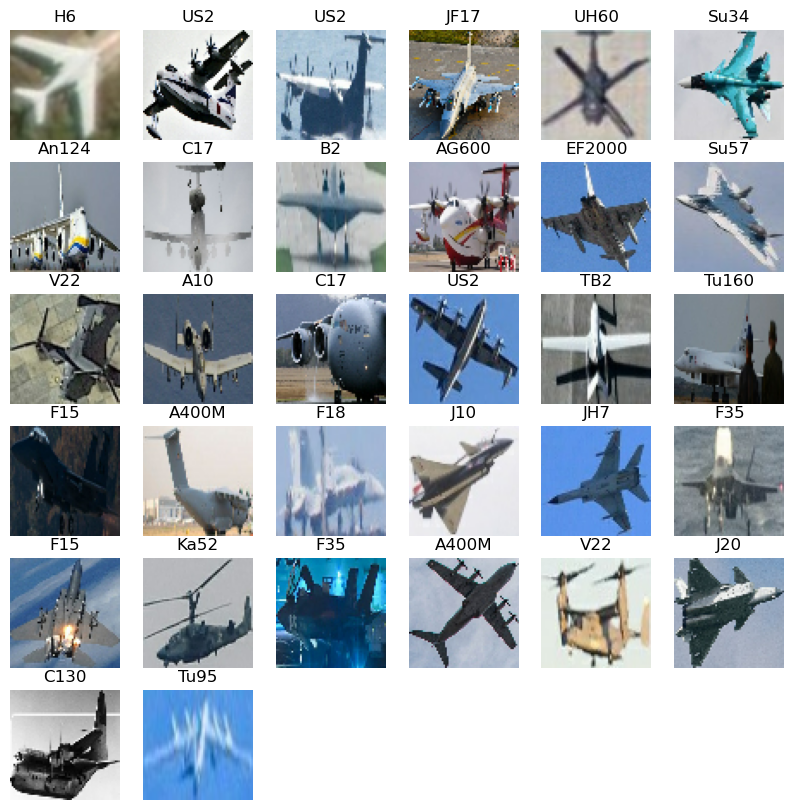

In [76]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(min(32, len(images))):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

AUTOTUNE = tf.data.AUTOTUNE
# allows the model to load the next batch while the model is training on the current batch, increasing efficiency
pf_train = train_data.prefetch(buffer_size=AUTOTUNE)
pf_test = test_data.prefetch(buffer_size=AUTOTUNE)
pf_val = val_data.prefetch(buffer_size=AUTOTUNE)

In [77]:
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal_and_vertical'))
data_augmentation.add(layers.RandomRotation(0.4))

In [81]:
preprocess_input = applications.resnet50.preprocess_input

IMG_SHAPE = imagesize + (3, )
base_model = applications.ResNet50(input_shape=IMG_SHAPE, include_top=False, weights = 'imagenet')
base_model.trainable = False
# base_model.summary()

nClass = len(class_names)

global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(nClass, activation = 'softmax')

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer_20[0… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [90]:
inputs = tf.keras.Input(shape = IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_18         │ (None, 64, 64)    │          0 │ input_layer_24[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_19         │ (None, 64, 64)    │          0 │ input_layer_24[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_20         │ (None, 64, 64)    │          0 │ input_layer_24[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_6 (Stack)     │ (None, 64, 64, 3) │          0 │ get_item_18[0][0… │
│                     │                   │            │ get_item_19[0][0… │
│                     │                   │            │ get_item_20[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 64, 64, 3) │          0 │ stack_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2, 2,      │ 23,587,712 │ add_6[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 2, 2, 512) │  9,437,696 │ resnet50[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 512) │      2,048 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 73)        │     37,449 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,064,905 (126.13 MB)

 Trainable params: 9,476,169 (36.15 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

In [91]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # For integer labels
              metrics=['accuracy'])

history = model.fit(pf_train, validation_data=(pf_val), epochs = 5)

Epoch 1/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 163s 230ms/step - accuracy: 0.2392 - loss: 3.3020 - val_accuracy: 0.4884 - val_loss: 1.9970
Epoch 2/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 165s 239ms/step - accuracy: 0.4842 - loss: 1.9079 - val_accuracy: 0.5846 - val_loss: 1.6092
Epoch 3/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 166s 239ms/step - accuracy: 0.6376 - loss: 1.3191 - val_accuracy: 0.6525 - val_loss: 1.3697
Epoch 4/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 164s 238ms/step - accuracy: 0.7784 - loss: 0.8149 - val_accuracy: 0.6975 - val_loss: 1.2458
Epoch 5/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 167s 241ms/step - accuracy: 0.8779 - loss: 0.4737 - val_accuracy: 0.7577 - val_loss: 1.0802


<font size = "5">**Code below is for EfficientNetV2B0 model**<font>

In [92]:
imagesize = 224,224 #224,224 in final
fullimagesize = 224,224,3 #224,224,3 in final

train_data_eff = image_dataset_from_directory(
    dataset_path,
    validation_split = 0.3,
    seed = 64,
    subset = 'training',
    image_size=(imagesize),  # Adjust the image size to 128 x 128 for faster processing
    batch_size=32,          # How many samples we want to load / batch
    shuffle=True            
)

valid_data_eff = image_dataset_from_directory(
    dataset_path,
    validation_split = 0.3,
    seed = 23,
    subset = 'validation',
    image_size=(imagesize),
    batch_size=32,
    shuffle=True
)

val_batches_eff = tf.data.experimental.cardinality(valid_data_eff) # takes the number of batches within the validation data
test_data_eff = valid_data_eff.take(val_batches_eff // 4) # takes the  
val_data_eff = valid_data_eff.skip(val_batches_eff // 4)

class_names_eff = train_data_eff.class_names

Found 31586 files belonging to 73 classes.
Using 22111 files for training.
Found 31586 files belonging to 73 classes.
Using 9475 files for validation.


2024-11-14 02:26:09.536966: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


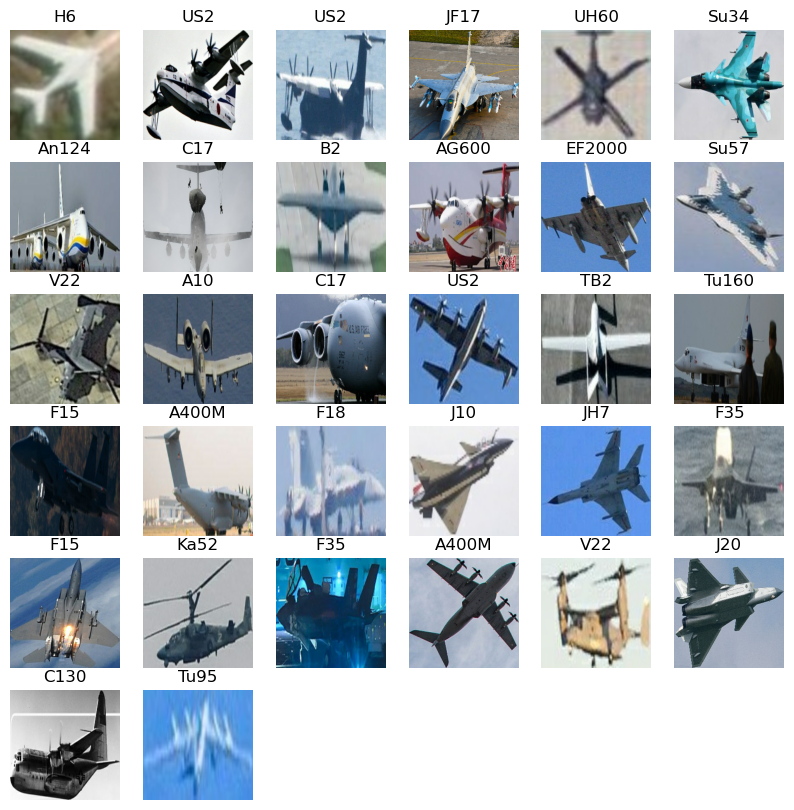

In [93]:
plt.figure(figsize=(10, 10))
for images, labels in train_data_eff.take(1):
    for i in range(min(32, len(images))):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

AUTOTUNE = tf.data.AUTOTUNE
# allows the model to load the next batch while the model is training on the current batch, increasing efficiency
pf_train_eff = train_data_eff.prefetch(buffer_size=AUTOTUNE)
pf_test_eff = test_data_eff.prefetch(buffer_size=AUTOTUNE)
pf_val_eff = val_data_eff.prefetch(buffer_size=AUTOTUNE)

In [94]:
base_model_eff = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(fullimagesize))  # Adjust input_shape as needed
base_model_eff.trainable = False  # Freeze the base model layers

for layer in base_model_eff.layers[-30:]:
    layer.trainable = True

# Max pooling layer replaces average pooling
global_max = layers.GlobalMaxPooling2D()

# Output layer
output_layer_eff = layers.Dense(len(class_names_eff), activation='softmax')

# Input layer
inputs = tf.keras.Input(shape=(fullimagesize))

# Preprocess the input
x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)

# Pass the input through the base model
x = base_model_eff(x)

# Apply global max pooling after the base model
x = global_max(x)

# Batch normalization (optional, can be added here)
x = layers.BatchNormalization()(x)

# Output layer
outputs_eff = output_layer_eff(x)

# Build the model
model = tf.keras.Model(inputs=inputs, outputs=outputs_eff)

# Print the model summary to verify
#model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # For integer labels
              metrics=['accuracy'])

model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 73)             │        93,513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,017,945 (22.96 MB)

 Trainable params: 1,259,945 (4.81 MB)

 Non-trainable params: 4,758,000 (18.15 MB)

In [95]:
history = model.fit(pf_train_eff, validation_data=(pf_val_eff), epochs = 5)

Epoch 1/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 238s 337ms/step - accuracy: 0.3697 - loss: 2.7107 - val_accuracy: 0.8226 - val_loss: 0.6605
Epoch 2/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 232s 336ms/step - accuracy: 0.7879 - loss: 0.7856 - val_accuracy: 0.8993 - val_loss: 0.3894
Epoch 3/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 232s 336ms/step - accuracy: 0.8918 - loss: 0.3957 - val_accuracy: 0.9237 - val_loss: 0.2991
Epoch 4/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 232s 335ms/step - accuracy: 0.9314 - loss: 0.2508 - val_accuracy: 0.9296 - val_loss: 0.3011
Epoch 5/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 228s 329ms/step - accuracy: 0.9429 - loss: 0.1983 - val_accuracy: 0.9330 - val_loss: 0.2820


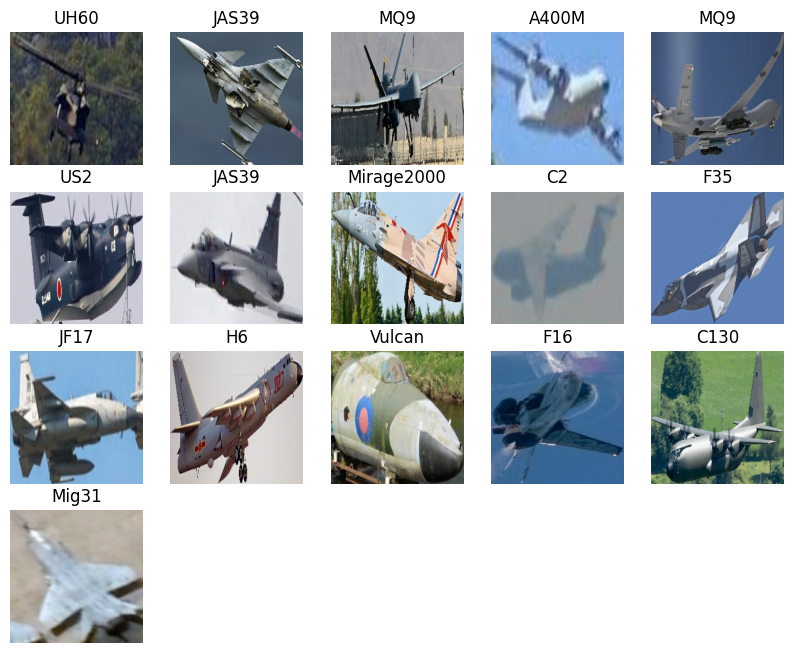

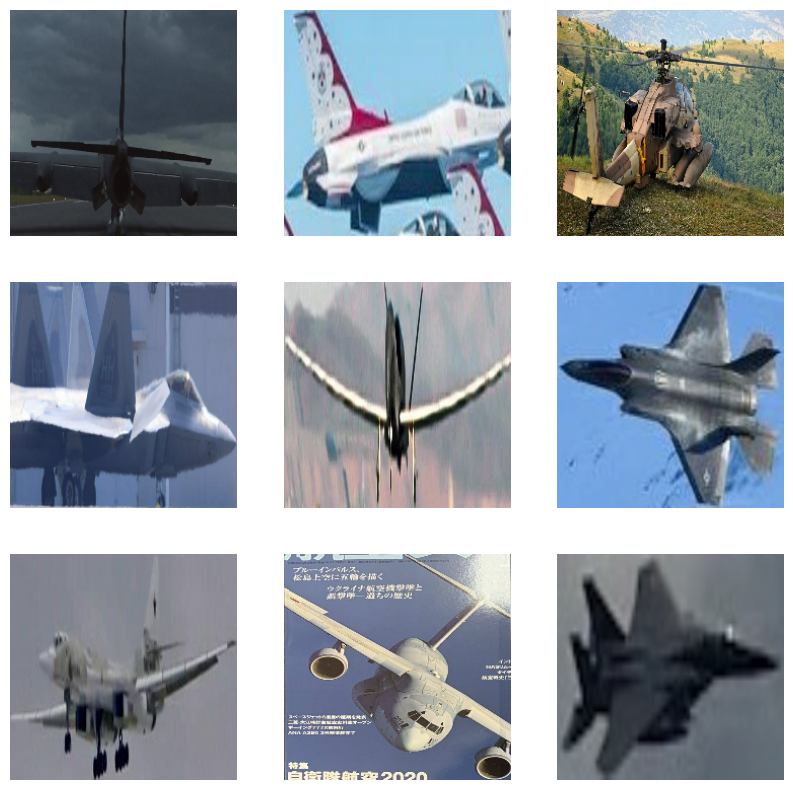

You must install pydot (`pip install pydot`) for `plot_model` to work.


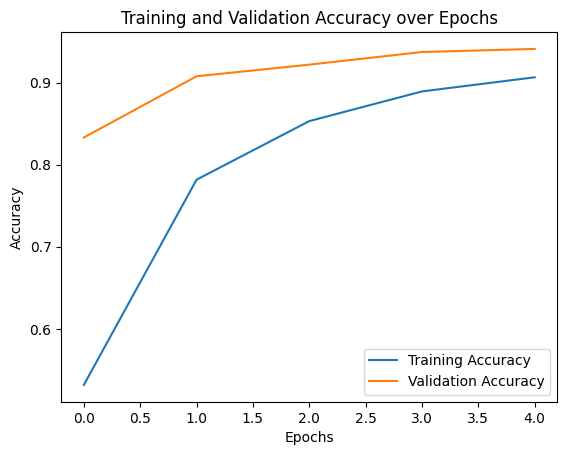

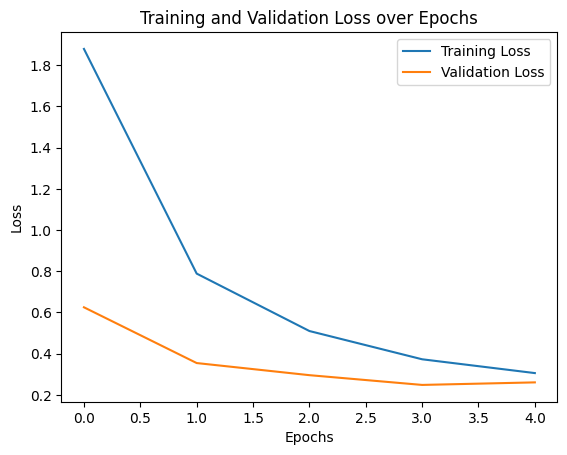

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(min(25, len(images))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

plt.figure(figsize=(10, 10))

# Take one batch from the training data
for images, _ in train_data.take(1):
    # Plot the first 9 images in a 3x3 grid
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert the tensor to numpy for plotting
        plt.axis("off")  # Remove axis for better visualization

plt.show()  # Display the plot

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()